In [17]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import signal
from scipy.fftpack import fft
%matplotlib inline

In [18]:
def ConeOutput(x,phi):
    alpha_c=2.4e-4 #-9.602e-6 in paper but used 2.4e-4 in code
    beta_c=1.148e-5
    alpha_h=.8
    gamma=.764
    tau_h=.371
    tau_z=.5769
    tau_y=.056
    Tk=np.arange(0,5,dt)
    Ky=Tk*np.exp(-Tk/tau_y)/tau_y**2 # linear filter for low pass filter
    Kz=gamma*Ky+(1-gamma)*Tk*np.exp(-Tk/tau_z)/tau_z**2 # linear filter for adaptation
    Kh=Tk*np.exp(-Tk/tau_h)/tau_h**2
    Ky=Ky/np.sum(Ky)
    Kz=Kz/np.sum(Kz)
    Kh=Kh/np.sum(Kh)
    plt.plot(Ky)
    plt.plot(Kz)
    plt.plot(Kh)
    plt.show()
    # y
    y=np.convolve(x,Ky,'full')
    y=y[0:len(x)]
    # z
    z=np.convolve(x,Kz,'full')
    z=z[0:len(x)]
    r=np.zeros(len(x))
    h=np.zeros(len(x))
    for i in range(len(x)-1):
        if i-len(Kh)+1<0:
            Kht=Kh[::-1][-i-1:len(Kh)]
            h[i]=alpha_h*sum(Kht*r[0:len(Kht)])
        else:
            Kht=Kh[::-1]
            h[i]=alpha_h*sum(Kht*r[i-len(Kht)+1:i+1])
        
        r[i]=alpha_c*y[i]/(1+beta_c*z[i])-phi*h[i]
    return r,h

In [19]:
# # OFF full gaussian pulse 
# T=np.linspace(-13,3,10000)
# dt=T[1]-T[0]
# pw=[0.6]
# maxp=154054
# for i in range(len(pw)):
#     x=np.zeros(len(T))
#     for j in range(len(T)):
#         x[j]=maxp*math.exp(-(T[j]/(math.sqrt(2)*(pw[i]/2.355)))**2)
# x=-x+max(x)
# plt.plot(T,x)

In [20]:
# # ON full gaussian pulse 
# T=np.linspace(-13,3,10000)
# dt=T[1]-T[0]
# pw=[0.6]
# maxp=154054
# for i in range(len(pw)):
#     x=np.zeros(len(T))
#     for j in range(len(T)):
#         x[j]=maxp*math.exp(-(T[j]/(math.sqrt(2)*(pw[i]/2.355)))**2)
# x=x+450
# plt.plot(T,x)

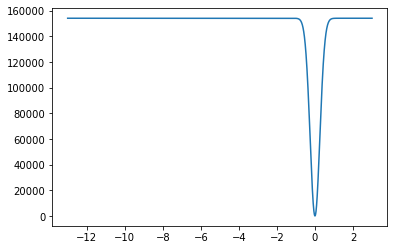

In [21]:
# OFF full gaussian pulse 
T=np.linspace(-13,3,10000)
dt=T[1]-T[0]
pw=[0.6]
maxp=154054
for i in range(len(pw)):
    x=np.zeros(len(T))
    for j in range(len(T)):
        x[j]=-maxp*math.exp(-(T[j]/(math.sqrt(2)*(pw[i]/2.355)))**2)
x=x-min(x)
plt.plot(T,x)

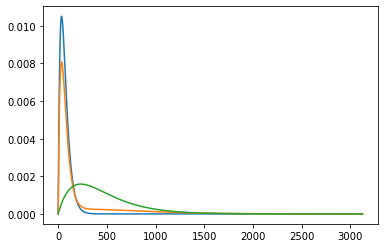

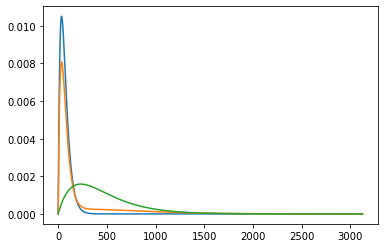

In [22]:
r,h=ConeOutput(x,1)
rb,hb=ConeOutput(x,0)
# r2,h2=ConeOutput2(x,1)
# r2b,h2b=ConeOutput2(x,0)
# r_RK,h_RK=ConeOutput_RK(T,x,1)

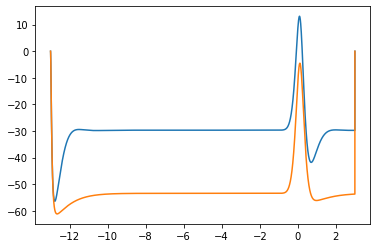

In [23]:
# plt.plot(T,x)
plt.plot(T,-4*r) # the cone output is multiplied by -4 in their code (I'm not sure why)
plt.plot(T,-4*rb)
# plt.plot(T,h)
# plt.show()
# plt.plot(T,r2)
# plt.plot(T,r2b)
# plt.plot(T,r_RK)
# plt.plot(T,h2)
plt.xlim()
plt.ylim()
plt.show()

(-1.0, 1.0)

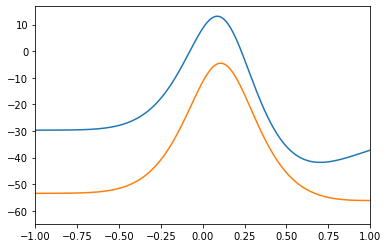

In [24]:
r1=-4*r
rb1=-4*rb
T1=np.copy(T)
plt.plot(T,r1)
plt.plot(T,rb1)
plt.xlim(-1,1)

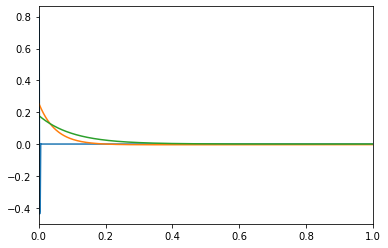

In [25]:
# kernels of bipolar pathway
mu=3e-3
sigma=1e-3
tau2=5e-2
tau3=1e-1
c2=50
TK=np.arange(dt,10,dt)
K1=np.sin(math.pi*TK/mu)/np.sqrt(2*math.pi*sigma)*np.exp(-1/2*((TK-mu)/sigma)**2)
K2=np.exp(-TK/tau2)/tau2-np.exp(-TK/c2/tau2)/c2/tau2
K3=np.exp(-TK/tau3)/tau3

K1=K1/np.sqrt(np.sum(K1**2))
K2=K2/np.sqrt(np.sum(K2**2))
K3=K3/np.sqrt(np.sum(K3**2))
plt.plot(TK,K1)
plt.plot(TK,K2)
plt.plot(TK,K3)
plt.xlim(0,1)
plt.show()

In [26]:
def bipolar(r_in):
    K_1_2_3=[K1,K2,K3]
    theta_p_k=[[0.1,-0.1],[0,0],[-23.5,-23.5]] # theta_p_k = theta[p][k]
    b_p_k=[[[] for i in range(2)] for j in range(3)]
    r_baseline=r_in+23
    for k in range(2):
        for p in range(3):
            btemp=(-1)**k*(np.convolve(r_baseline,K_1_2_3[p],'full')-theta_p_k[p][k])
            btemp=btemp[0:len(r_baseline)]
            btemp[btemp<0]=0
            b_p_k[p][k]=np.array(btemp)
    return b_p_k

(-2.0, 2.0)

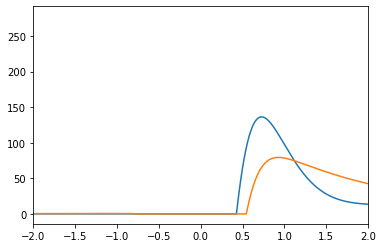

In [27]:
br=bipolar(r1)
brb=bipolar(rb1)
plt.plot(T1,br[1][1])
plt.plot(T1,brb[1][1]) 
plt.xlim(-2,2)

In [28]:
def rgc(w_gpk,alpha_g,theta_g,b):
    Ig=0
    for p in range(np.size(w_gpk,0)):
        for k in range(np.size(w_gpk,1)):
            Ig=Ig+w_gpk[p][k]*b[p][k]
    Kg=np.copy(K1)
    Ig_velocity=np.convolve(Ig,Kg,'full')
    Ig_velocity=Ig_velocity[0:len(Ig)]
    R=(1-alpha_g)*Ig+alpha_g*Ig_velocity-theta_g
    R[R<0]=0
    return R

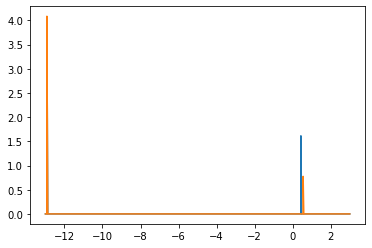

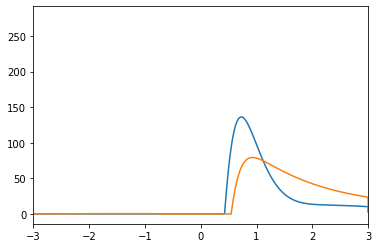

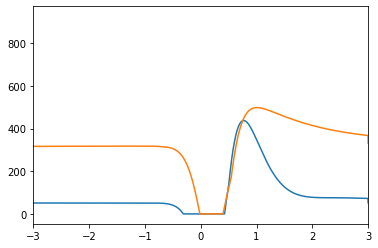

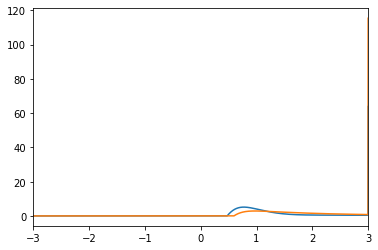

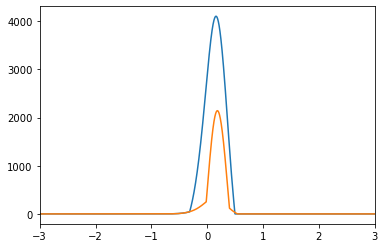

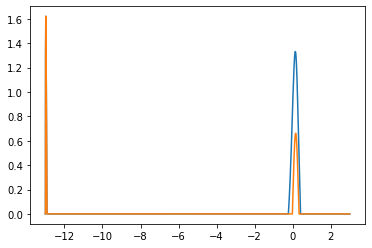

In [31]:
w1=[[0 for i in range(2)] for j in range(3)]
w1[1][1]=1
R1=rgc(w1,1,.3,br)
R1b=rgc(w1,1,.3,brb)
plt.plot(T1,R1)
plt.plot(T1,R1b)
plt.xlim()
plt.ylim()
plt.show()

w2=[[0 for i in range(2)] for j in range(3)]
w2[1][1]=1
R2=rgc(w2,0,.1,br)
R2b=rgc(w2,0,.1,brb)
plt.plot(T1,R2)
plt.plot(T1,R2b)
plt.xlim(-3,3)
plt.ylim()
plt.show()

w3=[[0 for i in range(2)] for j in range(3)]
w3[1][1]=2
w3[2][1]=1
R3=rgc(w3,0,0,br)
R3b=rgc(w3,0,0,brb)
plt.plot(T1,R3)
plt.plot(T1,R3b)
plt.xlim(-3,3)
plt.show()

w4=[[0 for i in range(2)] for j in range(3)]
w4[0][0]=3
w4[1][1]=-1
R4=rgc(w4,1,0,br)
R4b=rgc(w4,1,0,brb)
plt.plot(T1,R4)
plt.plot(T1,R4b)
plt.xlim(-3,3)
plt.show()

w5=[[0 for i in range(2)] for j in range(3)]
w5[1][0]=1
w5[2][0]=10
R5=rgc(w5,0,-0.1,br)
R5b=rgc(w5,0,-0.1,brb)
plt.plot(T1,R5)
plt.plot(T1,R5b)
plt.xlim(-3,3)
plt.show()

w6=[[0 for i in range(2)] for j in range(3)]
w6[0][1]=1
R6=rgc(w6,0,0,br)
R6b=rgc(w6,0,0,brb)
plt.plot(T1,R6)
plt.plot(T1,R6b)
plt.xlim()
plt.show()

In [30]:
# plot together
